<a href="https://colab.research.google.com/github/Epatsili2000/ParkinsonDetection/blob/main/Create_Spectogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mel-Spectrogram Generation for CNN Input

This notebook converts each `.wav` file into a fixed-size **Mel-spectrogram image** for convolutional neural network (CNN) training.

####  Input
- Source: `/PCGITA_RESULTS/pcgita_split_per_task.csv`
- Each row contains:
  - `Full_Path` to the `.wav` file
  - `Task`, `Label`, and `Speaker_ID` information
  - Target spectrogram filename constructed as:  
    `Task/Label/Speaker_ID/filename.png`

####  Processing Steps
For each audio file:
1. Load the waveform at 16 kHz and trim silence
2. Compute a **128-filter Mel-spectrogram**
3. Convert power to decibel scale (dB)
4. Save a **224×224 pixel PNG image** using the `inferno` colormap
5. Store the output path in the `spectrogram_path` column

Spectrograms are saved under:
/pcgita_images/mel/{Task}/{Label}/{Speaker_ID}/{filename}.png

In [ ]:
# -------------------- SETUP --------------------
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from pathlib import Path

# Paths
CSV_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_split_per_task.csv"
OUT_DIR = "/content/drive/MyDrive/pcgita_images/mel"
IMG_SIZE = (224, 224)  # Resize to 224x224
COLORMAP = 'inferno'

# Load CSV
df = pd.read_csv(CSV_PATH)

# Output path creation
def get_output_path(row):
    filename = os.path.splitext(os.path.basename(row["Full_Path"]))[0] + ".png"
    return os.path.join(OUT_DIR, row["Task"], row["Label"], row["Speaker_ID"], filename)

df["spectrogram_path"] = df.apply(get_output_path, axis=1)

# -------------------- GENERATE SPECTROGRAM --------------------
def save_mel_spectrogram(wav_path, save_path):
    try:
        y, sr = librosa.load(wav_path, sr=16000)
        y, _ = librosa.effects.trim(y)

        # Mel-spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)

        # Plot and save
        plt.figure(figsize=(2.24, 2.24), dpi=100)  # → 224x224
        librosa.display.specshow(S_dB, sr=sr, cmap=COLORMAP)
        plt.axis("off")
        plt.tight_layout(pad=0)

        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        return True
    except Exception as e:
        print(f" Failed for {wav_path}: {e}")
        return False

# -------------------- RUN BATCH GENERATION --------------------
success_count = 0
for _, row in tqdm(df.iterrows(), total=len(df)):
    wav_path = row["Full_Path"]
    save_path = row["spectrogram_path"]
    if not os.path.exists(save_path):  # Avoid reprocessing
        if save_mel_spectrogram(wav_path, save_path):
            success_count += 1

print(f" Done! {success_count}/{len(df)} spectrograms saved.")


100%|██████████| 6412/6412 [39:00<00:00,  2.74it/s]

✅ Done! 6411/6412 spectrograms saved.


In [ ]:
import os
import pandas as pd
import librosa
from tqdm import tqdm

# === CONFIG ===
CSV_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_split_per_task.csv"
OUTPUT_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_split_filtered.csv"
SKIPPED_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_split_skipped.csv"
MIN_DURATION_SEC = 0.3  # 300 ms
SR = 16000

# === Load original metadata ===
df = pd.read_csv(CSV_PATH)

# === Prepare filtered datasets ===
valid_rows = []
skipped_rows = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    wav_path = row["Full_Path"]

    try:
        if not os.path.exists(wav_path):
            raise FileNotFoundError("Missing file")

        y, sr = librosa.load(wav_path, sr=SR)
        duration = len(y) / sr

        if duration >= MIN_DURATION_SEC:
            valid_rows.append(row)
        else:
            row["reason"] = f"Too short ({duration:.2f}s)"
            skipped_rows.append(row)

    except Exception as e:
        row["reason"] = str(e)
        skipped_rows.append(row)

# === Save filtered and skipped CSVs ===
df_valid = pd.DataFrame(valid_rows)
df_skipped = pd.DataFrame(skipped_rows)

df_valid.to_csv(OUTPUT_CSV, index=False)
df_skipped.to_csv(SKIPPED_CSV, index=False)

print(f" Filtered CSV saved: {OUTPUT_CSV} ({len(df_valid)} valid samples)")
print(f" Skipped CSV saved: {SKIPPED_CSV} ({len(df_skipped)} skipped samples)")


100%|██████████| 6412/6412 [00:30<00:00, 209.98it/s]


✅ Filtered CSV saved: /content/drive/MyDrive/PCGITA_RESULTS/pcgita_split_filtered.csv (6405 valid samples)
⚠️ Skipped CSV saved: /content/drive/MyDrive/PCGITA_RESULTS/pcgita_split_skipped.csv (7 skipped samples)


### Filtering Invalid Audio Files

This notebook filters out audio samples that are too short or corrupted, ensuring only high-quality inputs are used in training.

####  Filtering Criteria:
- Each `.wav` file is checked for:
  - **Existence** on disk
  - **Minimum duration** of 300 milliseconds

####  Output:
Two CSV files are created:
-  `pcgita_split_filtered.csv`: Only valid samples with duration ≥ 0.3 sec
-  `pcgita_split_skipped.csv`: Skipped samples with a reason for exclusion (e.g., file not found, too short)

This step helps ensure the integrity of the dataset and prevents errors in downstream tasks like spectrogram generation or model training.


In [ ]:
# -------------------- SETUP --------------------
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random

# === CONFIG ===
CSV_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_split_filtered.csv"  # Use filtered CSV
OUT_DIR = "/content/drive/MyDrive/pcgita_images/mel_augmented"
IMG_SIZE = (224, 224)
COLORMAP = 'inferno'
SR = 16000

# === LOAD DATA ===
df = pd.read_csv(CSV_PATH)

# === Helper: Get output image path ===
def get_output_path(row, suffix=""):
    base = os.path.splitext(os.path.basename(row["Full_Path"]))[0]
    if suffix:
        base += f"_{suffix}"
    filename = base + ".png"
    return os.path.join(OUT_DIR, row["Task"], row["Label"], row["Speaker_ID"], filename)

# === Augmentation: time-stretch, pitch-shift ===
def augment_audio(y, sr):
    aug_list = [('orig', y)]

    try:
        y_stretch = librosa.effects.time_stretch(y, rate=random.uniform(0.9, 1.1))
        aug_list.append(('stretch', y_stretch))
    except:
        pass

    try:
        y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=random.choice([-1, 1]))
        aug_list.append(('pitch', y_pitch))
    except:
        pass

    return aug_list

# === Save Mel-Spectrogram Image ===
def save_mel_spectrogram(y, sr, save_path):
    try:
        y = librosa.util.normalize(y)
        y, _ = librosa.effects.trim(y)

        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)

        plt.figure(figsize=(2.24, 2.24), dpi=100)
        librosa.display.specshow(S_dB, sr=sr, cmap=COLORMAP)
        plt.axis("off")
        plt.tight_layout(pad=0)

        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        return True
    except Exception as e:
        print(f" Failed to save {save_path}: {e}")
        return False

# === GENERATE ===
success = 0

for _, row in tqdm(df.iterrows(), total=len(df)):
    wav_path = row["Full_Path"]
    try:
        y, sr = librosa.load(wav_path, sr=SR)
        augmentations = augment_audio(y, sr)

        for suffix, y_aug in augmentations:
            save_path = get_output_path(row, suffix=suffix)
            if not os.path.exists(save_path):
                if save_mel_spectrogram(y_aug, sr, save_path):
                    success += 1

    except Exception as e:
        print(f" Error reading {wav_path}: {e}")

print(f" Done! {success} spectrograms saved including augmentations.")


100%|██████████| 6405/6405 [31:29<00:00,  3.39it/s]

✅ Done! 19152 spectrograms saved including augmentations.


### Audio Augmentation Visualization with Mel-Spectrograms

This notebook demonstrates two common types of audio augmentation:
- **Time-stretching**: Makes the audio slower or faster without changing pitch
- **Pitch-shifting**: Changes pitch without altering duration

#### Configuration
- Audio is resampled to 16kHz and trimmed for silence
- Three mel-spectrograms are computed:
  - Original audio
  - Time-stretched (0.8× slower)
  - Pitch-shifted (+3 semitones)

#### Visualization
- All spectrograms are normalized with shared color scales (`vmin/vmax`) for accurate comparison
- A side-by-side plot shows how augmentation changes frequency content and duration


/tmp/ipython-input-4-420686500.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


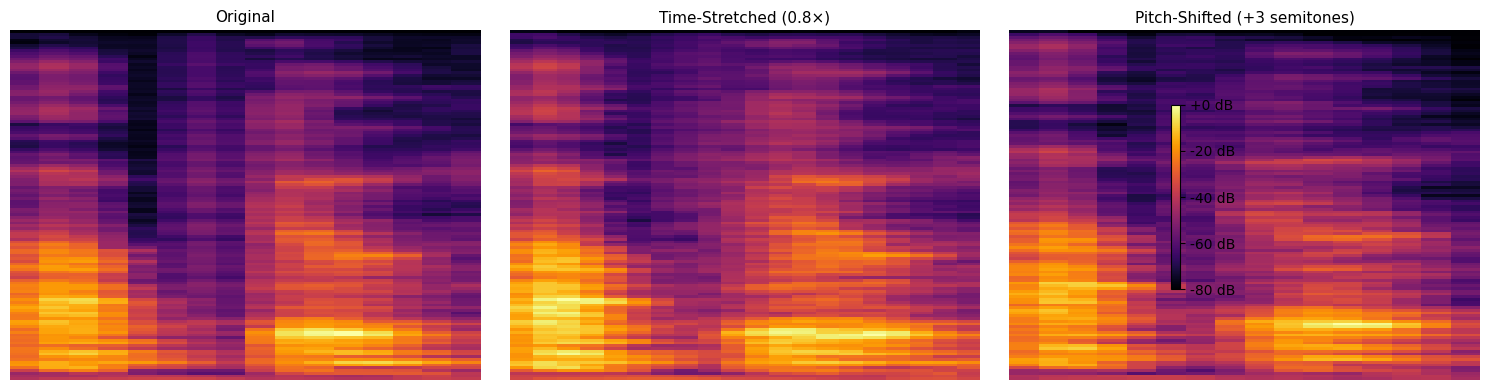

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# === CONFIG ===
AUDIO_PATH = "/content/drive/MyDrive/PC-GITA_per_task_44100Hz/PC-GITA_per_task_44100Hz/Words/Sin normalizar/Patologica/apto/AVPEPUDEA0001apto.wav"  # <-- Change this to your audio path
SR = 16000

# === LOAD AND TRIM ORIGINAL AUDIO ===
y_orig, _ = librosa.load(AUDIO_PATH, sr=SR)
y_orig, _ = librosa.effects.trim(y_orig)

# === AUGMENTATIONS ===
y_stretch = librosa.effects.time_stretch(y_orig, rate=0.8)  # slower
y_pitch = librosa.effects.pitch_shift(y_orig, sr=SR, n_steps=3)  # higher pitch

# === HELPER: Compute consistent dB-scaled mel-spectrogram ===
def compute_mel(y, sr):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

# === Compute all spectrograms and set shared vmin/vmax ===
S_orig = compute_mel(y_orig, SR)
S_stretch = compute_mel(y_stretch, SR)
S_pitch = compute_mel(y_pitch, SR)

vmin = min(S_orig.min(), S_stretch.min(), S_pitch.min())
vmax = max(S_orig.max(), S_stretch.max(), S_pitch.max())

# === PLOT COMPARISON ===
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for ax, S, title in zip(
    axs,
    [S_orig, S_stretch, S_pitch],
    ["Original", "Time-Stretched (0.8×)", "Pitch-Shifted (+3 semitones)"]
):
    img = librosa.display.specshow(S, sr=SR, cmap=COLORMAP, ax=ax, vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=11)
    ax.axis('off')

fig.colorbar(img, ax=axs, format='%+2.0f dB', orientation='vertical', shrink=0.6)
plt.tight_layout()
plt.show()

# === OPTIONAL: Save figure ===
# fig.savefig("comparison_spectrograms.png", dpi=150, bbox_inches='tight')



### Metadata Extraction for Augmented Mel-Spectrograms

After generating mel-spectrograms with augmentations (original, time-stretch, and pitch-shift), this notebook collects metadata from the folder structure and saves it as a CSV for downstream training.

#### Folder Structure Parsed:
/pcgita_images/mel_augmented/{Task}/{Label}/{Speaker_ID}/{Filename}.png


####  Extracted Metadata Includes:
- `filename`: Full path to the spectrogram image
- `label`: PD or HC
- `speaker_id`: Participant identifier
- `task`: Speech task (e.g., monologue, words)
- `augmentation`: Type of augmentation:
  - `orig`: Original spectrogram
  - `stretch`: Time-stretched
  - `pitch`: Pitch-shifted
- `basename`: Base audio name without augmentation suffix

####  Output:
Saved as:
 /PCGITA_RESULTS/mel_metadata_augmented.csv


In [ ]:
import os
import pandas as pd

# === CONFIG ===
IMAGE_ROOT = "/content/drive/MyDrive/pcgita_images/mel_augmented"
OUTPUT_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/mel_metadata_augmented.csv"
AUG_SUFFIXES = ['orig', 'stretch', 'pitch']

# === Collect metadata from folder ===
data = []

for root, _, files in os.walk(IMAGE_ROOT):
    for fname in files:
        if not fname.endswith(".png"):
            continue

        full_path = os.path.join(root, fname)
        rel_path = os.path.relpath(full_path, IMAGE_ROOT)

        try:
            parts = rel_path.split(os.sep)
            task = parts[0]
            label = parts[1]
            speaker_id = parts[2]

            base = os.path.splitext(fname)[0]
            for suffix in AUG_SUFFIXES:
                if base.endswith(f"_{suffix}"):
                    basename = base.rsplit(f"_{suffix}", 1)[0]
                    augmentation = suffix
                    break
            else:
                basename = base
                augmentation = "unknown"

            data.append({
                "filename": full_path,
                "label": label,
                "speaker_id": speaker_id,
                "task": task,
                "augmentation": augmentation,
                "basename": basename
            })

        except Exception as e:
            print(f" Skipped: {full_path} → {e}")

# === Save CSV ===
df_meta = pd.DataFrame(data)
df_meta.to_csv(OUTPUT_CSV, index=False)
print(f" Metadata saved to: {OUTPUT_CSV} ({len(df_meta)} entries)")


✅ Metadata saved to: /content/drive/MyDrive/PCGITA_RESULTS/mel_metadata_augmented.csv (19212 entries)


### MFCC Plot Generation for CNN Input

This notebook generates 2D image representations of MFCC features for each `.wav` file, enabling CNN-based classification directly from MFCC plots.

####  Input
- Source: `/PCGITA_RESULTS/pcgita_split_per_task.csv`
- Each audio file is processed to extract **13 MFCC coefficients**

####  Plotting Details
- The MFCCs are converted to decibel scale
- Each MFCC matrix is rendered as a 224×224 pixel image using the `inferno` colormap
- Output images are saved in:

/pcgita_images/mfcc/{Task}/{Label}/{Speaker_ID}/{filename}.png


####  Output
- Total plots generated are printed at the end
- These MFCC plots can be used as an alternative to mel-spectrograms for CNN training


In [ ]:
# -------------------- SETUP --------------------
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# === CONFIG ===
CSV_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_split_per_task.csv"
OUT_DIR = "/content/drive/MyDrive/pcgita_images/mfcc"
IMG_SIZE = (224, 224)
COLORMAP = "inferno"
SR = 16000

# === LOAD FILE SPLIT ===
df = pd.read_csv(CSV_PATH)

# === Construct output image path ===
def get_output_path(row):
    filename = os.path.splitext(os.path.basename(row["Full_Path"]))[0] + ".png"
    return os.path.join(OUT_DIR, row["Task"], row["Label"], row["Speaker_ID"], filename)

df["mfcc_path"] = df.apply(get_output_path, axis=1)

# === MFCC PLOT SAVER ===
def save_mfcc_plot(wav_path, save_path):
    try:
        y, sr = librosa.load(wav_path, sr=SR)
        y, _ = librosa.effects.trim(y)

        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))

        # Plot MFCCs
        plt.figure(figsize=(2.24, 2.24), dpi=100)  # 224x224
        librosa.display.specshow(mfccs_db, sr=sr, cmap=COLORMAP, x_axis=None, y_axis=None)
        plt.axis('off')
        plt.tight_layout(pad=0)

        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        return True
    except Exception as e:
        print(f" Failed: {wav_path} → {e}")
        return False

# === GENERATE MFCC PLOTS ===
success = 0
for _, row in tqdm(df.iterrows(), total=len(df)):
    wav_path = row["Full_Path"]
    save_path = row["mfcc_path"]
    if not os.path.exists(save_path):
        if save_mfcc_plot(wav_path, save_path):
            success += 1

print(f" MFCC plots saved: {success}/{len(df)}")


100%|██████████| 6412/6412 [1:22:18<00:00,  1.30it/s]

✅ MFCC plots saved: 6411/6412


### MFCC Plot Generation with Data Augmentation

This notebook extends basic MFCC plot generation by applying audio augmentations and saving one image per variation to increase training diversity.

####  Augmentation Types
For each `.wav` file:
- `orig`: Original signal
- `stretch`: Time-stretch (±10% speed)
- `pitch`: Pitch-shift (±1 semitone)

Each version is converted into a 224×224 MFCC image using the `inferno` colormap.

####  Output Structure
Images are saved to:
/pcgita_images/mfcc_augmented/{Task}/{Label}/{Speaker_ID}/{basename}_{suffix}.png

Where `{suffix}` is one of `orig`, `stretch`, or `pitch`.

####  CSV Used:
- Input: `pcgita_split_filtered.csv` (only valid audio samples)
- Sampling rate: 16 kHz
- Total image count printed after execution


In [ ]:
# -------------------- SETUP --------------------
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random

# === CONFIG ===
CSV_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_split_filtered.csv"
OUT_DIR = "/content/drive/MyDrive/pcgita_images/mfcc_augmented"
COLORMAP = "inferno"
SR = 16000
IMG_SIZE = (224, 224)
AUG_SUFFIXES = ['orig', 'stretch', 'pitch']

# === LOAD SPLIT CSV ===
df = pd.read_csv(CSV_PATH)

# === Output Path Constructor ===
def get_output_path(row, suffix=""):
    base = os.path.splitext(os.path.basename(row["Full_Path"]))[0]
    if suffix:
        base += f"_{suffix}"
    filename = base + ".png"
    return os.path.join(OUT_DIR, row["Task"], row["Label"], row["Speaker_ID"], filename)

# === Audio Augmentation ===
def augment_audio(y, sr):
    aug_list = [('orig', y)]
    try:
        y_stretch = librosa.effects.time_stretch(y, rate=random.uniform(0.9, 1.1))
        aug_list.append(('stretch', y_stretch))
    except:
        pass
    try:
        y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=random.choice([-1, 1]))
        aug_list.append(('pitch', y_pitch))
    except:
        pass
    return aug_list

# === Save MFCC Plot ===
def save_mfcc_plot(y, sr, save_path):
    try:
        y = librosa.util.normalize(y)
        y, _ = librosa.effects.trim(y)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))

        plt.figure(figsize=(2.24, 2.24), dpi=100)
        librosa.display.specshow(mfccs_db, sr=sr, cmap=COLORMAP)
        plt.axis('off')
        plt.tight_layout(pad=0)

        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        return True
    except Exception as e:
        print(f" Failed to save {save_path}: {e}")
        return False

# === MAIN LOOP ===
success = 0

for _, row in tqdm(df.iterrows(), total=len(df)):
    wav_path = row["Full_Path"]
    try:
        y, sr = librosa.load(wav_path, sr=SR)
        augmentations = augment_audio(y, sr)

        for suffix, y_aug in augmentations:
            save_path = get_output_path(row, suffix=suffix)
            if not os.path.exists(save_path):
                if save_mfcc_plot(y_aug, sr, save_path):
                    success += 1
    except Exception as e:
        print(f" Error loading {wav_path}: {e}")

print(f" MFCC plots saved including augmentations: {success}")


100%|██████████| 6405/6405 [25:47<00:00,  4.14it/s]

✅ MFCC plots saved including augmentations: 19212


### Metadata Extraction for Augmented MFCC Plots

This notebook parses the folder structure of augmented MFCC image files and creates a metadata CSV for use in CNN model training.

####  Directory Format
The augmented images are expected to be stored in:
/pcgita_images/mfcc_augmented/{Task}/{Label}/{Speaker_ID}/{basename}_{suffix}.png

Where:
- `{suffix}` is one of:
  - `orig` (original)
  - `stretch` (time-stretched)
  - `pitch` (pitch-shifted)

####  Extracted Fields:
Each row in the resulting metadata CSV contains:
- `filename`: Full path to image
- `label`: PD or HC
- `speaker_id`: Participant ID
- `task`: Speech task
- `augmentation`: Augmentation type
- `basename`: Original sample name (without suffix)

####  Output:
/PCGITA_RESULTS/mfcc_metadata_augmented.csv

In [ ]:
import os
import pandas as pd

# === CONFIG ===
IMAGE_ROOT = "/content/drive/MyDrive/pcgita_images/mfcc_augmented"
OUTPUT_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/mfcc_metadata_augmented.csv"
AUG_SUFFIXES = ['orig', 'stretch', 'pitch']

# === Collect metadata ===
data = []

for root, _, files in os.walk(IMAGE_ROOT):
    for fname in files:
        if not fname.endswith(".png"):
            continue

        full_path = os.path.join(root, fname)
        rel_path = os.path.relpath(full_path, IMAGE_ROOT)

        try:
            parts = rel_path.split(os.sep)
            task = parts[0]
            label = parts[1]
            speaker_id = parts[2]

            base = os.path.splitext(fname)[0]
            for suffix in AUG_SUFFIXES:
                if base.endswith(f"_{suffix}"):
                    basename = base.rsplit(f"_{suffix}", 1)[0]
                    augmentation = suffix
                    break
            else:
                basename = base
                augmentation = "unknown"

            data.append({
                "filename": full_path,
                "label": label,
                "speaker_id": speaker_id,
                "task": task,
                "augmentation": augmentation,
                "basename": basename
            })

        except Exception as e:
            print(f" Skipped: {full_path} → {e}")

# === Save CSV ===
df_meta = pd.DataFrame(data)
df_meta.to_csv(OUTPUT_CSV, index=False)
print(f" Metadata saved to: {OUTPUT_CSV} ({len(df_meta)} entries)")


✅ Metadata saved to: /content/drive/MyDrive/PCGITA_RESULTS/mfcc_metadata_augmented.csv (19212 entries)


### Generate Log-Spectrograms (No Augmentation)

This notebook converts raw `.wav` audio files into 224×224 pixel **log-spectrogram** images using the Short-Time Fourier Transform (STFT).

#### Configuration:
- Sampling Rate: 16,000 Hz
- FFT window size: 1024
- Hop length: 512
- Colormap: inferno
- Image Size: 224×224

#### Output Path Structure:
/pcgita_images/logspec/{Task}/{Label}/{Speaker_ID}/{filename}.png

In [ ]:
# -------------------- SETUP --------------------
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# === CONFIG ===
CSV_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_split_per_task.csv"
OUT_DIR = "/content/drive/MyDrive/pcgita_images/logspec"
IMG_SIZE = (224, 224)
COLORMAP = "inferno"
SR = 16000

# === LOAD SPLIT CSV ===
df = pd.read_csv(CSV_PATH)

# === Construct output image path ===
def get_output_path(row):
    filename = os.path.splitext(os.path.basename(row["Full_Path"]))[0] + ".png"
    return os.path.join(OUT_DIR, row["Task"], row["Label"], row["Speaker_ID"], filename)

df["logspec_path"] = df.apply(get_output_path, axis=1)

# === LOG-SPECTROGRAM PLOT SAVER ===
def save_log_spectrogram(wav_path, save_path):
    try:
        y, sr = librosa.load(wav_path, sr=SR)
        y, _ = librosa.effects.trim(y)

        # Linear spectrogram
        stft = librosa.stft(y, n_fft=1024, hop_length=512)
        S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

        # Plot
        plt.figure(figsize=(2.24, 2.24), dpi=100)
        librosa.display.specshow(S_db, sr=sr, cmap=COLORMAP)
        plt.axis("off")
        plt.tight_layout(pad=0)

        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
        plt.close()
        return True
    except Exception as e:
        print(f" Failed: {wav_path} → {e}")
        return False

# === GENERATE LOG-SPECTROGRAM IMAGES ===
success = 0
for _, row in tqdm(df.iterrows(), total=len(df)):
    wav_path = row["Full_Path"]
    save_path = row["logspec_path"]
    if not os.path.exists(save_path):
        if save_log_spectrogram(wav_path, save_path):
            success += 1

print(f" Log-spectrograms saved: {success}/{len(df)}")


100%|██████████| 6412/6412 [31:37<00:00,  3.38it/s]

✅ Log-spectrograms saved: 6411/6412


### Generate Augmented Log-Spectrograms

This notebook creates log-spectrograms from filtered `.wav` files, applying three variants per sample:
- Original
- Time-stretched (0.9×–1.1×)
- Pitch-shifted (+/- 1 semitone)

####  Processing Details:
- Sampling Rate: 16,000 Hz
- STFT: n\_fft=1024, hop\_length=512
- Spectrogram size: 224×224 pixels
- Colormap: inferno

####  Augmentations Applied:
- `orig`: Original trimmed waveform
- `stretch`: Time-stretch with random rate
- `pitch`: Pitch shift with ±1 semitone

####  Output Directory Structure:
/pcgita_images/logspec_augmented/{Task}/{Label}/{Speaker_ID}/{basename}_{suffix}.png

In [ ]:
# -------------------- SETUP --------------------
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random

# === CONFIG ===
CSV_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_split_filtered.csv"
OUT_DIR = "/content/drive/MyDrive/pcgita_images/logspec_augmented"
COLORMAP = "inferno"
SR = 16000
IMG_SIZE = (224, 224)
AUG_SUFFIXES = ['orig', 'stretch', 'pitch']

# === LOAD SPLIT CSV ===
df = pd.read_csv(CSV_PATH)

# === Output Path Generator ===
def get_output_path(row, suffix=""):
    base = os.path.splitext(os.path.basename(row["Full_Path"]))[0]
    if suffix:
        base += f"_{suffix}"
    filename = base + ".png"
    return os.path.join(OUT_DIR, row["Task"], row["Label"], row["Speaker_ID"], filename)

# === Audio Augmentation ===
def augment_audio(y, sr):
    aug_list = [('orig', y)]
    try:
        y_stretch = librosa.effects.time_stretch(y, rate=random.uniform(0.9, 1.1))
        aug_list.append(('stretch', y_stretch))
    except:
        pass
    try:
        y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=random.choice([-1, 1]))
        aug_list.append(('pitch', y_pitch))
    except:
        pass
    return aug_list

# === Save Log-Spectrogram ===
def save_log_spectrogram(y, sr, save_path):
    try:
        y = librosa.util.normalize(y)
        y, _ = librosa.effects.trim(y)
        stft = librosa.stft(y, n_fft=1024, hop_length=512)
        S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

        plt.figure(figsize=(2.24, 2.24), dpi=100)
        librosa.display.specshow(S_db, sr=sr, cmap=COLORMAP)
        plt.axis("off")
        plt.tight_layout(pad=0)

        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
        plt.close()
        return True
    except Exception as e:
        print(f" Failed to save {save_path}: {e}")
        return False

# === MAIN LOOP ===
success = 0

for _, row in tqdm(df.iterrows(), total=len(df)):
    wav_path = row["Full_Path"]
    try:
        y, sr = librosa.load(wav_path, sr=SR)
        augmentations = augment_audio(y, sr)

        for suffix, y_aug in augmentations:
            save_path = get_output_path(row, suffix=suffix)
            if not os.path.exists(save_path):
                if save_log_spectrogram(y_aug, sr, save_path):
                    success += 1
    except Exception as e:
        print(f" Error loading {wav_path}: {e}")

print(f" Log-spectrograms saved including augmentations: {success}")


 97%|█████████▋| 6238/6405 [27:56<13:27,  4.83s/it]

### Metadata Extraction for Augmented Log-Spectrograms

This notebook creates a metadata table for log-spectrogram images stored in:

/pcgita_images/logspec_augmented/{Task}/{Label}/{Speaker_ID}/{basename}_{suffix}.png

####  Input Directory Structure
- `Task`: Speech task (e.g., monologue, vowels)
- `Label`: PD or HC
- `Speaker_ID`: Unique participant ID
- `{suffix}`: Indicates augmentation type:
  - `orig`: Original
  - `stretch`: Time-stretched
  - `pitch`: Pitch-shifted

####  Metadata Fields Collected
- `filename`: Full path to image
- `label`: PD or HC
- `speaker_id`: Participant ID
- `task`: Speech task
- `augmentation`: `orig`, `stretch`, `pitch`, or `unknown`
- `basename`: File base name without augmentation suffix

####  Output
Metadata is saved to:
 /PCGITA_RESULTS/logspec_metadata_augmented.csv

In [ ]:
import os
import pandas as pd

# === CONFIG ===
IMAGE_ROOT = "/content/drive/MyDrive/pcgita_images/logspec_augmented"
OUTPUT_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/logspec_metadata_augmented.csv"
AUG_SUFFIXES = ['orig', 'stretch', 'pitch']

# === Collect metadata ===
data = []

for root, _, files in os.walk(IMAGE_ROOT):
    for fname in files:
        if not fname.endswith(".png"):
            continue

        full_path = os.path.join(root, fname)
        rel_path = os.path.relpath(full_path, IMAGE_ROOT)

        try:
            parts = rel_path.split(os.sep)
            task = parts[0]
            label = parts[1]
            speaker_id = parts[2]

            base = os.path.splitext(fname)[0]
            for suffix in AUG_SUFFIXES:
                if base.endswith(f"_{suffix}"):
                    basename = base.rsplit(f"_{suffix}", 1)[0]
                    augmentation = suffix
                    break
            else:
                basename = base
                augmentation = "unknown"

            data.append({
                "filename": full_path,
                "label": label,
                "speaker_id": speaker_id,
                "task": task,
                "augmentation": augmentation,
                "basename": basename
            })

        except Exception as e:
            print(f" Skipped: {full_path} → {e}")

# === Save CSV ===
df_meta = pd.DataFrame(data)
df_meta.to_csv(OUTPUT_CSV, index=False)
print(f" Metadata saved to: {OUTPUT_CSV} ({len(df_meta)} entries)")


✅ Metadata saved to: /content/drive/MyDrive/PCGITA_RESULTS/logspec_metadata_augmented.csv (18713 entries)


###  Ensemble Metadata Merging (Mel + MFCC + Log-Spectrogram)

This notebook merges metadata from three types of spectrogram-based image inputs:
- **Mel-spectrograms**
- **MFCC plots**
- **Log-spectrograms**

The goal is to prepare a unified metadata file for training **ensemble CNN models** that take multiple views of the same speech signal as input.

####  Merge Keys
Each entry is matched across all views using:
- `task`, `label`, `speaker_id`, `augmentation`, `basename`

This ensures that the mel, MFCC, and log-spectrogram images refer to the **same original `.wav` file** and augmentation type.

####  Input Files:
- `mel_metadata_augmented.csv`
- `mfcc_metadata_augmented.csv`
- `logspec_metadata_augmented.csv`

####  Output File:
Saved as:
/PCGITA_RESULTS/ensemble_metadata_merged.csv


####  Columns:
- `filename_mel`: Path to mel-spectrogram image
- `filename_mfcc`: Path to MFCC plot image
- `filename_logspec`: Path to log-spectrogram image
- Plus: `label`, `speaker_id`, `task`, `augmentation`, `basename`

This file is used to build multi-branch ensemble CNN models.

In [ ]:
# -------------------- SETUP --------------------
import pandas as pd
import os

# === CONFIG ===
MEL_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/mel_metadata_augmented.csv"
MFCC_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/mfcc_metadata_augmented.csv"
LOGSPEC_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/logspec_metadata_augmented.csv"
OUTPUT_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/ensemble_metadata_merged.csv"

# === LOAD ===
df_mel = pd.read_csv(MEL_CSV)
df_mfcc = pd.read_csv(MFCC_CSV)
df_logspec = pd.read_csv(LOGSPEC_CSV)

# === SANITY: Ensure consistent keys ===
key_cols = ["task", "label", "speaker_id", "augmentation", "basename"]

# Add task column if missing (for older versions)
for df in [df_mel, df_mfcc, df_logspec]:
    if "task" not in df.columns:
        df["task"] = df["filename"].apply(lambda x: x.split(os.sep)[-4])

# === Merge by keys ===
df_merged = df_mel.merge(
    df_mfcc, on=key_cols, suffixes=("_mel", "_mfcc")
).merge(
    df_logspec, on=key_cols
).rename(columns={"filename": "filename_logspec"})

# Final column order
df_merged = df_merged[[
    "filename_mel", "filename_mfcc", "filename_logspec",
    "label", "speaker_id", "task", "augmentation", "basename"
]]

# === SAVE ===
df_merged.to_csv(OUTPUT_CSV, index=False)
print(f" Ensemble metadata saved: {OUTPUT_CSV} ({len(df_merged)} entries)")


✅ Ensemble metadata saved: /content/drive/MyDrive/PCGITA_RESULTS/ensemble_metadata_merged.csv (18713 entries)
